# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series
from pandas.plotting import lag_plot

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

import math
from math import sqrt

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# Loading dataset

In [2]:
flight_4 = pd.read_csv("Combined_Data_Apr21.csv")
flight_5 = pd.read_csv("Combined_Data_May21.csv")
flight_6 = pd.read_csv("Combined_Data_Jun21.csv")
flight_4 = flight_4.append(flight_5)
flight_4 = flight_4.append(flight_6)
light = flight_4[["Timestamp", "Num_Flights", "Num_Covid_Cases"]]

In [3]:
light

,Timestamp,Num_Flights,Num_Covid_Cases
0,2021-04-01,1,22467.0
1,2021-04-01,2,1152.0
2,2021-04-01,34,2373153.0
3,2021-04-01,306,29341.0
4,2021-04-01,108,552729.0
...,...,...,...
2906,2021-06-30,9881,15182.0
2907,2021-06-30,55,487.0
2908,2021-06-30,1,0.0
2909,2021-06-30,55,545.0


In [4]:
data = light.groupby(by=["Timestamp"]).sum()
data.reset_index()
data

,Num_Flights,Num_Covid_Cases
Timestamp,,
2021-04-01,22172,121043182.0
2021-04-02,22133,581019.0
2021-04-03,20228,473933.0
2021-04-04,19946,510425.0
2021-04-05,20539,449404.0
...,...,...
2021-06-26,24179,325744.0
2021-06-27,24558,266822.0
2021-06-28,23978,288210.0


In [5]:
data.to_csv('data.csv')

# Visualizing train data

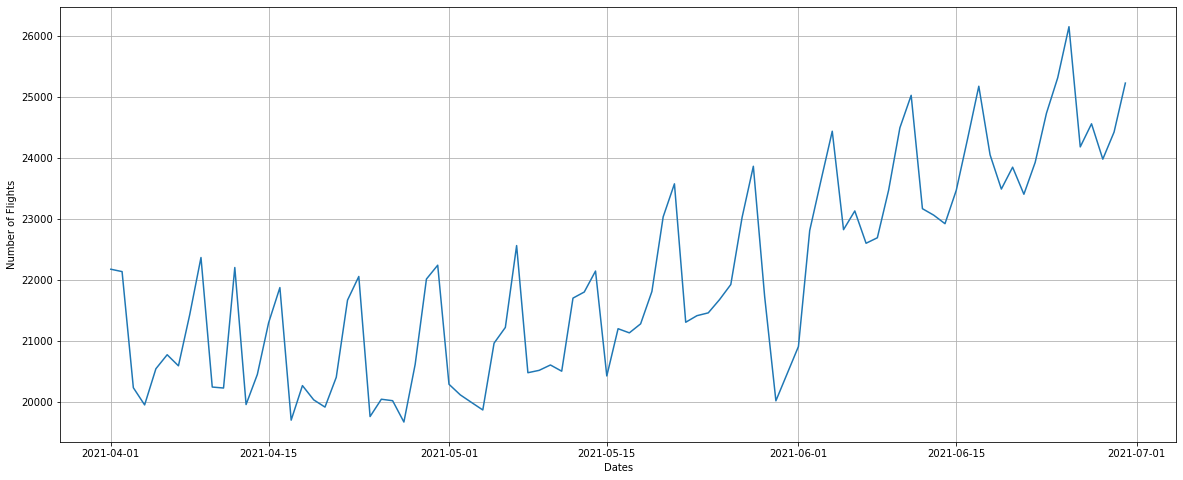

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data.csv', sep=',', parse_dates=['Timestamp'], index_col='Timestamp',date_parser=dateparse)
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Number of Flights')
plt.plot(data['Num_Flights']);
plt.show()

# Plotting autocorrelation

No handles with labels found to put in legend.


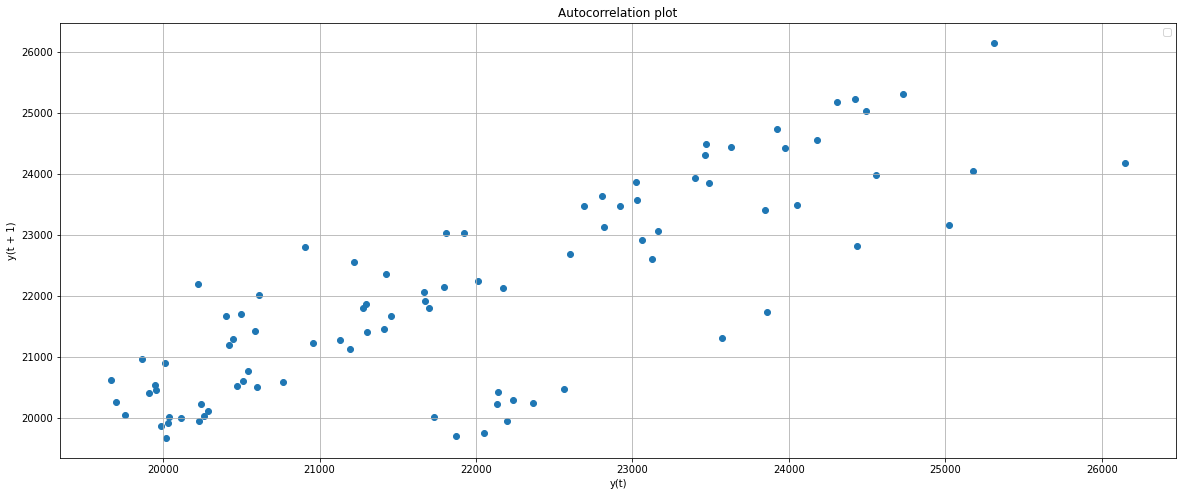

In [7]:
plt.figure(figsize=(20,8))
lag_plot(data['Num_Flights'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend();

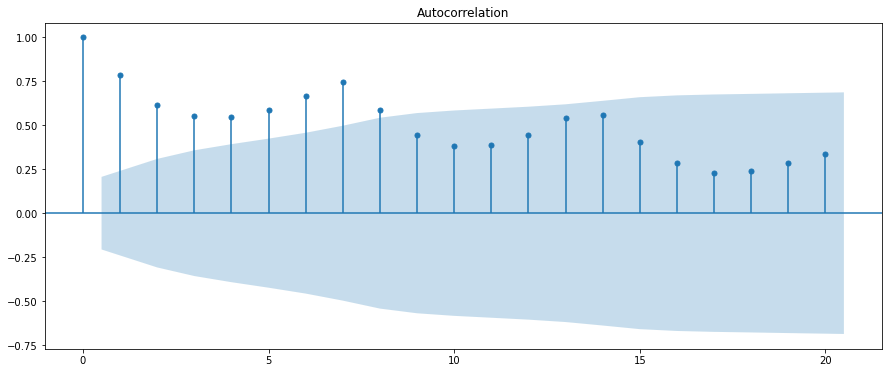

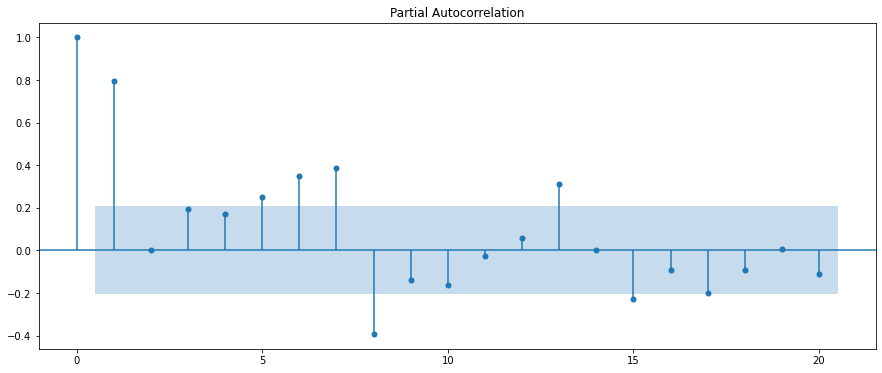

In [8]:
fig1=plot_acf(data['Num_Flights'].dropna()) 
fig2=plot_pacf(data['Num_Flights'].dropna()) 

In [9]:
values = DataFrame(data['Num_Flights'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

     t-1  t+1
t-1  NaN  NaN
t+1  NaN  1.0


In [10]:
data.tail()

,Num_Flights,Num_Covid_Cases
Timestamp,,
2021-06-26,24179,325744.0
2021-06-27,24558,266822.0
2021-06-28,23978,288210.0
2021-06-29,24422,334241.0
2021-06-30,25226,345862.0


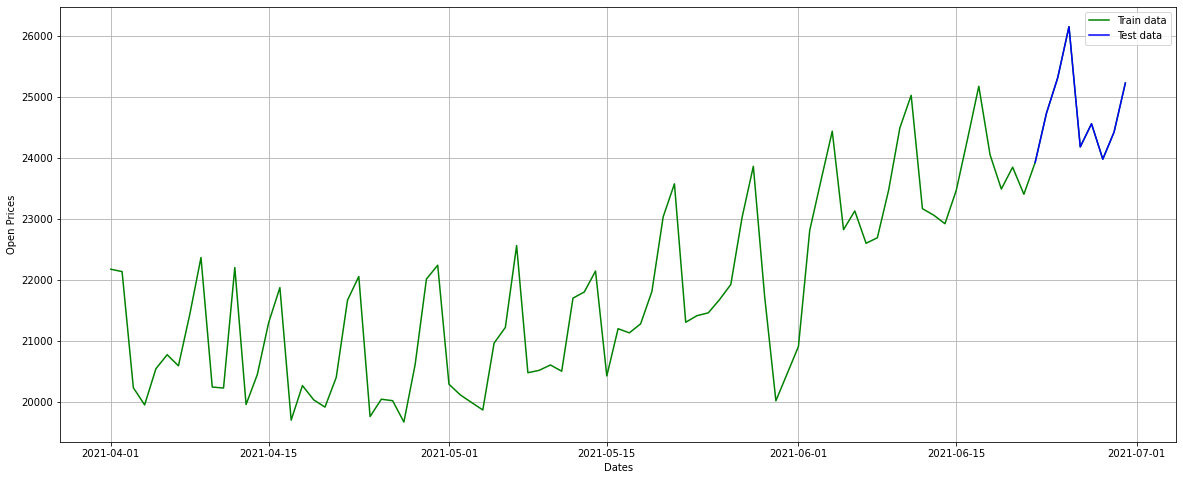

In [11]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Num_Flights'], 'green', label='Train data')
plt.plot(test_data['Num_Flights'], 'blue', label='Test data')
plt.legend()

# Autoregression model

In [12]:
train_ar = train_data['Num_Flights']
test_ar = test_data['Num_Flights']

# train autoregression
model = AR(train_ar)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [13]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      N  -                  u                  m
Model:                         AR(11)   Log Likelihood                -549.491
Method:                          cmle   S.D. of innovations            620.753
Date:                Thu, 03 Mar 2022   AIC                             13.233
Time:                        22:06:41   BIC                             13.651
Sample:                             0   HQIC                            13.399
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1241.8136   1949.861     -0.637      0.524   -5063.472    2579.844
L1.Num_Flights      0.3632      0.131      2.767      0.006       0.106       0.620
L2.Num_Flights     -0.1121      0.139     -0.809      0.419      -0.384       0.160
L3.Num_Flights      0.0655      0.137      0.477      0.634      -0.204       0.335
L4.Num_Flights      0.1472      0.139      1.063      0.288      -0.124       0.419
L5.Num_Flights      0.0190      0.108      0.175      0.861      -0.193       0.231
L6.Num_Flights      0.2019      0.107      1.886      0.059      -0.008       0.412
L7.Num_Flights      0.6325      0.110      5.740      0.000       0.417       0.848
L8.Num_Flights     -0.1601      0.137     -1.167      0.243      -0.429       0.109
L9.Num_Flights      0.0804      0.139      0.579      0.562      -0.192       0.352
L10.Num_Flights    -0.1224      0.137     -0.890      0.373      -0.392       0.147
L11.Num_Flights    -0.0494      0.137     -0.360      0.719      -0.319       0.220
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9844           -0.0000j            0.9844           -0.0000
AR.2             0.6168           -0.8126j            1.0201           -0.1467
AR.3             0.6168           +0.8126j            1.0201            0.1467
AR.4            -1.0021           -0.4355j            1.0926           -0.4347
AR.5            -1.0021           +0.4355j            1.0926            0.4347
AR.6             1.5452           -0.0000j            1.5452           -0.0000
AR.7            -0.2577           -1.0684j            1.0990           -0.2877
AR.8            -0.2577           +1.0684j            1.0990            0.2877
AR.9            -0.1178           -1.5905j            1.5949           -0.2618
AR.10           -0.1178           +1.5905j            1.5949            0.2618
AR.11           -3.4829           -0.0000j            3.4829           -0.5000
------------------------------------------------------------------------------
"""

In [14]:
# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history

Timestamp
2021-06-11    25025
2021-06-12    23165
2021-06-13    23059
2021-06-14    22919
2021-06-15    23466
2021-06-16    24307
2021-06-17    25174
2021-06-18    24049
2021-06-19    23487
2021-06-20    23846
2021-06-21    23402
Name: Num_Flights, dtype: int64

In [15]:
history = [history[i] for i in range(len(history))]

In [16]:
predictions = list()

In [17]:
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)

Lag: 11


Text(0, 0.5, 'Number of Flights')

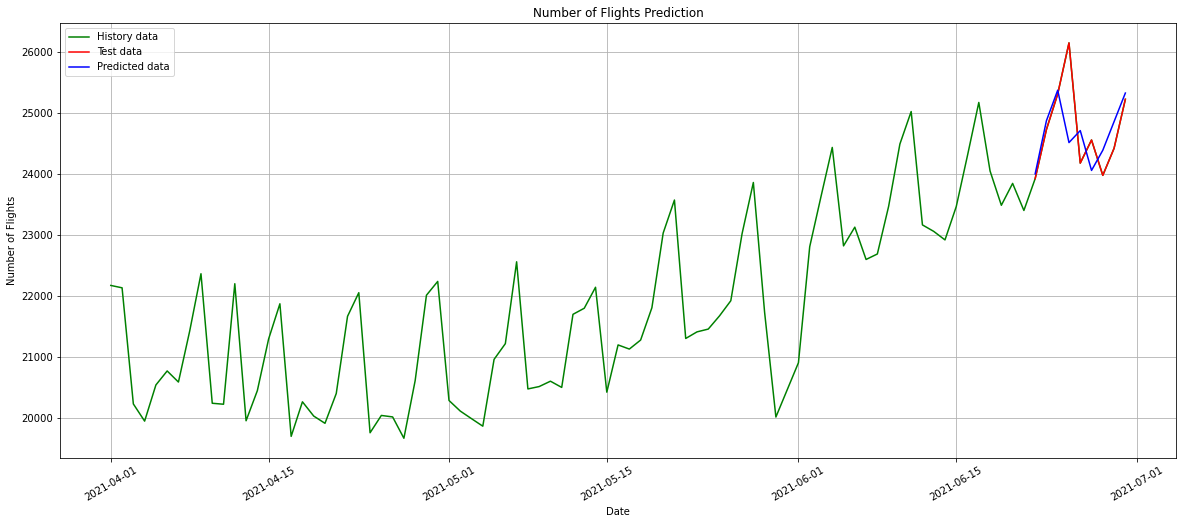

In [18]:
plt.figure(figsize=(20,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-600:], data['Num_Flights'].tail(600), color='green', label='History data')
plt.plot(test_data.index, test_data['Num_Flights'], color='red', label='Test data')
plt.plot(test_data.index, predictions, color='blue', label='Predicted data')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.title('Number of Flights Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Flights')

# Performance and Evaluation

In [19]:
mse = mean_squared_error(test_data['Num_Flights'], predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Num_Flights'], predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Num_Flights'], predictions))
print('RMSE: '+str(rmse))
me = max_error(test_data['Num_Flights'], predictions)
print('ME: '+str(me))
score = r2_score(test_data['Num_Flights'], predictions)
print('r2 score: '+str(score))
result = adfuller(data['Num_Flights'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

plt.savefig('ar_model.pdf')

MSE: 401201.1160916856
MAE: 433.97859504535114
RMSE: 633.4043859113115
ME: 1635.1968556946667
r2 score: 0.14988854754623682


<Figure size 1080x432 with 0 Axes>